In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('loan.csv')

In [3]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0 

In [4]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [5]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Property_Area'] = df['Property_Area'].map({'Urban': 2, 'Semiurban': 1, 'Rural': 0})
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

In [6]:
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
df.drop(columns=['Loan_ID'], inplace=True)

In [7]:
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
model_dir = 'models'
model_path = os.path.join(model_dir, 'scaler.pkl')
os.makedirs(model_dir, exist_ok=True)
joblib.dump(scaler, model_path)

['models/scaler.pkl']

In [10]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} ROC-AUC Score: {roc_auc}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return accuracy, roc_auc

In [11]:
log_reg = LogisticRegression(random_state=42, max_iter=200)
log_reg.fit(X_train, y_train)
evaluate_model(log_reg, X_test, y_test, "Logistic Regression")

Logistic Regression Accuracy: 0.8617886178861789
Logistic Regression ROC-AUC Score: 0.8024767801857585
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

Confusion Matrix:
 [[22 16]
 [ 1 84]]


(0.8617886178861789, 0.8024767801857585)

In [12]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
evaluate_model(rf_clf, X_test, y_test, "Random Forest")

Random Forest Accuracy: 0.8211382113821138
Random Forest ROC-AUC Score: 0.8294117647058824
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.61      0.68        38
           1       0.84      0.92      0.88        85

    accuracy                           0.82       123
   macro avg       0.80      0.76      0.78       123
weighted avg       0.82      0.82      0.81       123

Confusion Matrix:
 [[23 15]
 [ 7 78]]


(0.8211382113821138, 0.8294117647058824)

In [13]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
evaluate_model(gb_clf, X_test, y_test, "Gradient Boosting")

Gradient Boosting Accuracy: 0.8048780487804879
Gradient Boosting ROC-AUC Score: 0.7473684210526316
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.58      0.65        38
           1       0.83      0.91      0.87        85

    accuracy                           0.80       123
   macro avg       0.78      0.74      0.76       123
weighted avg       0.80      0.80      0.80       123

Confusion Matrix:
 [[22 16]
 [ 8 77]]


(0.8048780487804879, 0.7473684210526316)

In [14]:
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)
evaluate_model(xgb_clf, X_test, y_test, "XGBoost")

XGBoost Accuracy: 0.7886178861788617
XGBoost ROC-AUC Score: 0.7972136222910217
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.64        38
           1       0.83      0.87      0.85        85

    accuracy                           0.79       123
   macro avg       0.75      0.74      0.74       123
weighted avg       0.78      0.79      0.79       123

Confusion Matrix:
 [[23 15]
 [11 74]]


(0.7886178861788617, 0.7972136222910217)

In [15]:
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=StratifiedKFold(5), n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [16]:
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
param_grid_gb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5]}
param_grid_xgb = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]}

In [17]:
best_log_reg = hyperparameter_tuning(log_reg, param_grid_log_reg, X_train, y_train)
evaluate_model(best_log_reg, X_test, y_test, "Best Logistic Regression")
joblib.dump(best_log_reg, os.path.join('models', 'best_log_reg_model.pkl'))

Best Logistic Regression Accuracy: 0.8536585365853658
Best Logistic Regression ROC-AUC Score: 0.8015479876160991
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123

Confusion Matrix:
 [[21 17]
 [ 1 84]]


['models/best_log_reg_model.pkl']

In [18]:
best_rf_clf = hyperparameter_tuning(rf_clf, param_grid_rf, X_train, y_train)
evaluate_model(best_rf_clf, X_test, y_test, "Best Random Forest")
joblib.dump(best_rf_clf, os.path.join('models', 'best_rf_clf_model.pkl'))

Best Random Forest Accuracy: 0.8536585365853658
Best Random Forest ROC-AUC Score: 0.8089783281733747
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.58      0.71        38
           1       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123

Confusion Matrix:
 [[22 16]
 [ 2 83]]


['models/best_rf_clf_model.pkl']

In [19]:
best_gb_clf = hyperparameter_tuning(gb_clf, param_grid_gb, X_train, y_train)
evaluate_model(best_gb_clf, X_test, y_test, "Best Gradient Boosting")
joblib.dump(best_gb_clf, os.path.join('models', 'best_gb_clf_model.pkl'))

Best Gradient Boosting Accuracy: 0.8373983739837398
Best Gradient Boosting ROC-AUC Score: 0.8089783281733747
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.53      0.67        38
           1       0.82      0.98      0.89        85

    accuracy                           0.84       123
   macro avg       0.87      0.75      0.78       123
weighted avg       0.85      0.84      0.82       123

Confusion Matrix:
 [[20 18]
 [ 2 83]]


['models/best_gb_clf_model.pkl']

In [20]:
best_xgb_clf = hyperparameter_tuning(xgb_clf, param_grid_xgb, X_train, y_train)
evaluate_model(best_xgb_clf, X_test, y_test, "Best XGBoost")
joblib.dump(best_xgb_clf, os.path.join('models', 'best_xgb_clf_model.pkl'))

Best XGBoost Accuracy: 0.8455284552845529
Best XGBoost ROC-AUC Score: 0.8003095975232198
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.55      0.69        38
           1       0.83      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.87      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123

Confusion Matrix:
 [[21 17]
 [ 2 83]]


['models/best_xgb_clf_model.pkl']

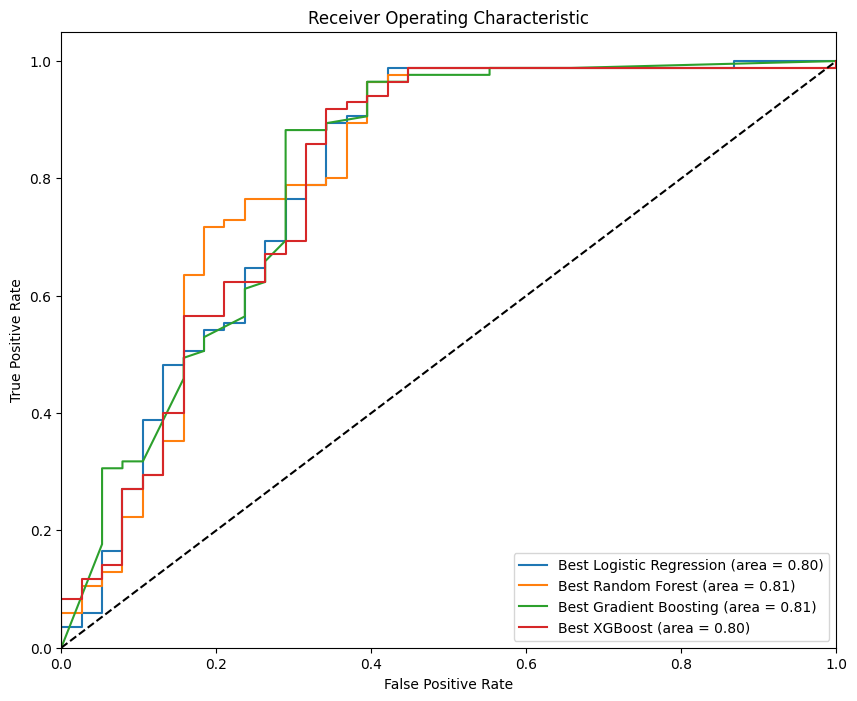

In [21]:
plt.figure(figsize=(10, 8))
models = [("Best Logistic Regression", best_log_reg), ("Best Random Forest", best_rf_clf), ("Best Gradient Boosting", best_gb_clf), ("Best XGBoost", best_xgb_clf)]
for name, model in models:
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (area = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()